##### We start by importing the necessary libraries and modules required for data preprocessing, natural language processing (NLP), and machine learning. These libraries will be used throughout the project for various tasks.


In [1]:
#importing libraries
import numpy as np 
import pandas as pd 
import re 
import nltk 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline 
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

##### Loading the training and testing datasets. We read the data from CSV files, rename columns, and standardize the sentiment labels by replacing "Irrelevant" with "Neutral".


In [2]:
train_df = pd.read_csv('/Users/mani/Desktop/DataDen/Twitter Sentiment Analysis/Dataset/twitter_training.csv',header= None)
train_df.columns =['Id', 'Entity', 'Sentiment', 'Tweet']
train_df['Sentiment'] = train_df['Sentiment'].replace('Irrelevant', 'Neutral')
train_df.head()

test_df = pd.read_csv('/Users/mani/Desktop/DataDen/Twitter Sentiment Analysis/Dataset/twitter_validation.csv',header= None)
test_df.columns =['Id', 'Entity', 'Sentiment', 'Tweet']
test_df['Sentiment'] = train_df['Sentiment'].replace('Irrelevant', 'Neutral')

##### Checking for null values

In [3]:
train_df.isnull().sum()

Id             0
Entity         0
Sentiment      0
Tweet        686
dtype: int64

##### Getting rid of null values

In [4]:
train_df=train_df.dropna()

##### cleaning_URLs function to get rid of URLs in the tweet

In [5]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|([^s]+.com)|(https?://[^s]+))','',data)

# Apply the cleaning_URLs to the tweet column
train_df['Tweet'] = train_df['Tweet'].apply(cleaning_URLs)

##### cleaning_numbers function to get rid of numbers in the tweet

In [6]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)

# Apply the cleaning_numbers_udf to the clean_text column
train_df['Tweet'] = train_df['Tweet'].apply(cleaning_numbers)

##### cleaning_punctation function

In [7]:
def cleaning_punctation(data):
    return re.sub('[^a-zA-Z#]+', ' ', data)

# Apply the cleaning_numbers_udf to the clean_text column
train_df['Tweet'] = train_df['Tweet'].apply(cleaning_punctation)

In [8]:
#removing all emails in the text 
pattern_to_remove = r'\S+@\S+'  
# Use str.replace() to remove the pattern from the 'text_column'
train_df['Tweet'] = train_df['Tweet'].str.replace(pattern_to_remove, '', regex=True)

In [9]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

train_df['Tweet'] = train_df['Tweet'].apply(remove_stopwords)

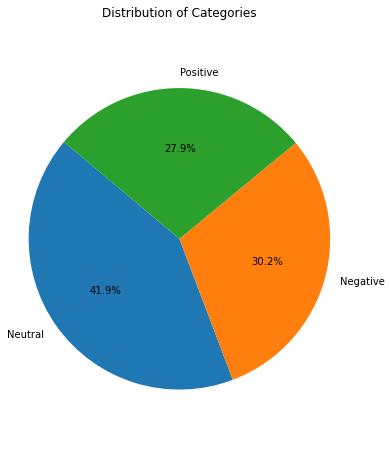

In [10]:
# Count the occurrences of each category
category_counts = train_df['Sentiment'].value_counts()

# Plot a pie chart
plt.figure(figsize=(6, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal') 

plt.title('Distribution of Categories')
plt.show()

Text(0.5, 0, 'Sentiment')

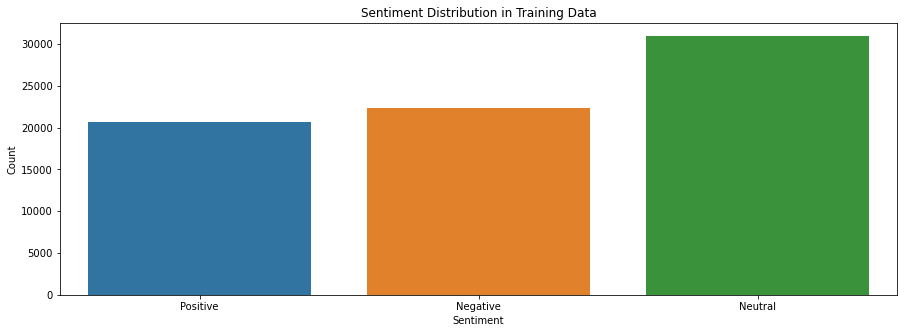

In [11]:
# Set up the plots
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

# Plot sentiment distribution for training data
sns.countplot(data=train_df, x=train_df['Sentiment'], order=['Positive', 'Negative', 'Neutral'], ax=ax)
ax.set_title('Sentiment Distribution in Training Data')
ax.set_ylabel('Count')
ax.set_xlabel('Sentiment')

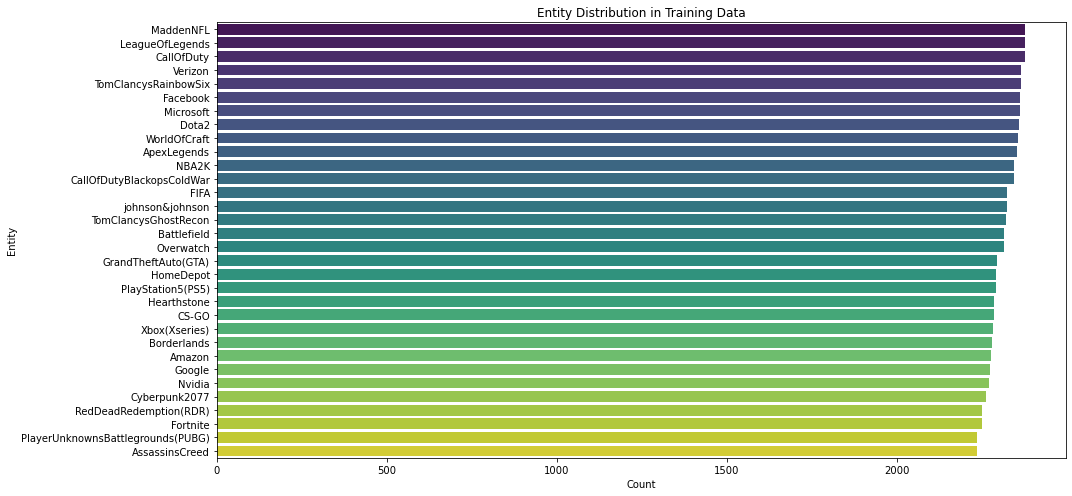

In [12]:
# Set up the plot
plt.figure(figsize=(15, 7))

# Plot entity distribution for training data
sns.countplot(data=train_df, y=train_df["Entity"], order=train_df["Entity"].value_counts().index, palette='viridis')
plt.title('Entity Distribution in Training Data')
plt.xlabel('Count')
plt.ylabel('Entity')
plt.tight_layout()
plt.show()

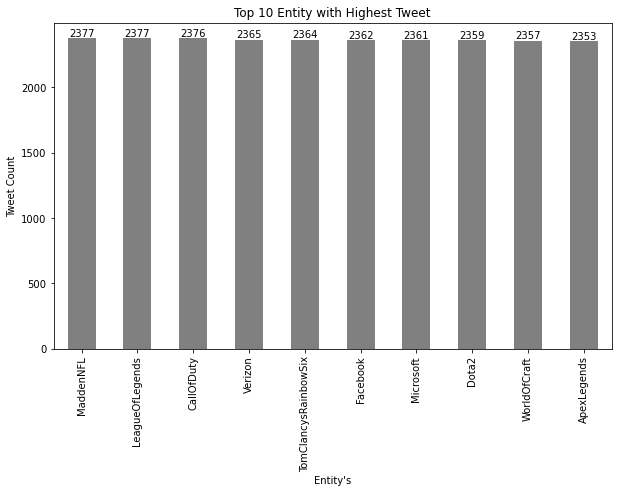

In [13]:
# Count the occurrences of each category
entity_counts = train_df['Entity'].value_counts()

# Select the top 10 categories
top_10_entity = entity_counts.head(10)


# Plot a bar graph for the top 10 categories
plt.figure(figsize=(10, 6))
top_10_entity.plot(kind='bar', color='Grey')

for i, count in enumerate(entity_counts):
    plt.annotate(str(count), (i, count), ha='center', va='bottom')
    
plt.xlabel("Entity's")
plt.ylabel('Tweet Count')
plt.title('Top 10 Entity with Highest Tweet')
plt.xticks(rotation=90)
plt.show()

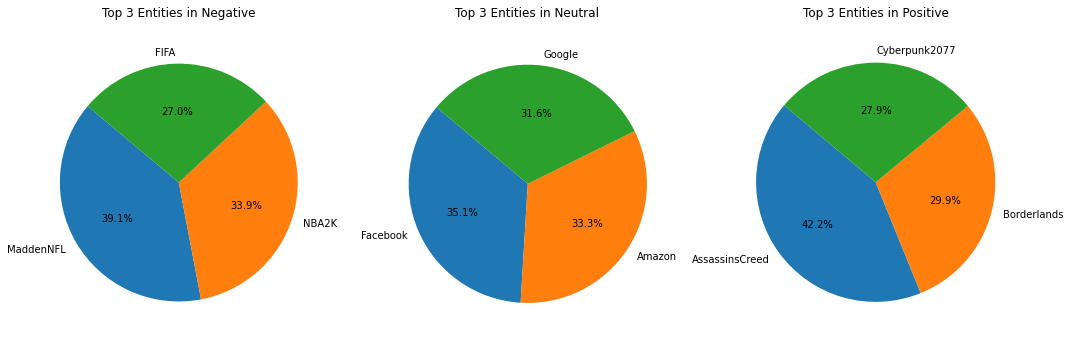

In [14]:
# Group the data by 'tweet_category' and 'entity' and count occurrences
category_entity_counts = train_df.groupby(['Sentiment', 'Entity']).size().unstack(fill_value=0)

# Create a list to store the top 3 entities for each category
top_three_entities = []

# Iterate through each category
for category in category_entity_counts.index:
    top_entities = category_entity_counts.loc[category].nlargest(3)
    top_three_entities.append(top_entities)

# Create subplots for each category
plt.figure(figsize=(15, 5))
for i, (category, top_entities) in enumerate(zip(category_entity_counts.index, top_three_entities)):
    plt.subplot(1, 3, i + 1)
    plt.pie(top_entities, labels=top_entities.index, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.title(f'Top 3 Entities in {category}')

plt.tight_layout()
plt.show()

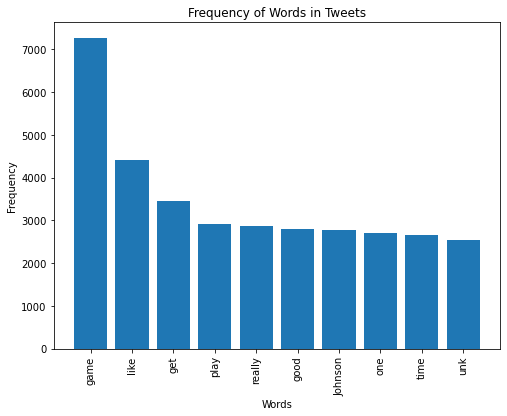

In [15]:
# Combine all the text into a single string
all_text = " ".join(train_df["Tweet"])

# Split the text into words and explode them into separate rows
word_list = all_text.split()
word_df = pd.DataFrame({"word": word_list})

# Count the frequency of each word and display the top 10
word_df_freq = word_df["word"].value_counts().reset_index()
word_df_freq.columns = ["word", "count"]
top_10_words = word_df_freq.head(10)

plt.figure(figsize=(8, 6))
plt.bar(top_10_words['word'], top_10_words['count'])
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Frequency of Words in Tweets')
plt.xticks(rotation=90)
plt.show()

In [16]:
# to find how many unique words in the vocabulary
unique_words_count = train_df['Tweet'].nunique()
print("Number of unique words:", unique_words_count)

Number of unique words: 60753


In [17]:
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words="english")
bow = bow_vectorizer.fit_transform(train_df['Tweet'])

In [18]:
#spliting the cleaned data into test and train
X_train, X_test, y_train, y_test = train_test_split(bow, train_df['Sentiment'], test_size=0.2, random_state=69)

# Na√Øve Bayes Model

In [19]:
#using naive bayes model to make predicitons 
model_naive = MultinomialNB().fit(X_train,y_train)
pred = model_naive.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, pred))

Accuracy:  0.6038513513513514


In [20]:
#custom function to calculate the models accuracy 
def accuracy(pred, y_test):
    l=0
    for i,j in zip(pred, y_test):
        if i==j:
            l=l+1
    return l/len(pred)

# Decision Tree Classifier

In [21]:
#using Decision Tress Classifier to make prediction 
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)
preds=model.predict(X_train)
print("Accuracy: ", accuracy(preds,y_train))

Accuracy:  0.9236941685249004


# Logistic Regression

In [22]:
# using Logistic Regression
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train, y_train)

# Make predictions
logistic_preds = logistic_model.predict(X_test)

# Calculate and print accuracy
logistic_accuracy = accuracy(logistic_preds, y_test)
print("Accuracy: ",logistic_accuracy)

Accuracy:  0.6258108108108108


# Random Forest Classifier

In [23]:
# using Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
rf_preds = rf_model.predict(X_test)

# Calculate and print accuracy
rf_accuracy = accuracy(rf_preds, y_test)
print("Accuracy: ", rf_accuracy)

Accuracy:  0.851418918918919


# Performance Evaluation

In [24]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluation of the Multinomial Naive Bayes model
print("Multinomial Naive Bayes Model:")
print("Accuracy: {:.3f}".format(accuracy_score(y_test, pred)))
print("Confusion Matrix:")
print(confusion_matrix(y_test, pred))
print("Classification Report:")
print(classification_report(y_test, pred))

# Evaluation of the Decision Tree Classifier
print("\nDecision Tree Classifier:")
decision_tree_preds = model.predict(X_test)
print("Accuracy: {:.3f}".format(accuracy(decision_tree_preds, y_test)))
print("Confusion Matrix:")
print(confusion_matrix(y_test, decision_tree_preds))
print("Classification Report:")
print(classification_report(y_test, decision_tree_preds))

# Evaluation of the Logistic Regression model
print("\nLogistic Regression Model:")
print("Accuracy: {:.3f}".format(logistic_accuracy))
logistic_preds = logistic_model.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, logistic_preds))
print("Classification Report:")
print(classification_report(y_test, logistic_preds))

# Evaluation of the Random Forest Classifier
print("\nRandom Forest Classifier:")
print("Accuracy: {:.3f}".format(rf_accuracy))
rf_preds = rf_model.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, rf_preds))
print("Classification Report:")
print(classification_report(y_test, rf_preds))


Multinomial Naive Bayes Model:
Accuracy: 0.604
Confusion Matrix:
[[2740 1248  484]
 [1088 3930 1198]
 [ 513 1332 2267]]
Classification Report:
              precision    recall  f1-score   support

    Negative       0.63      0.61      0.62      4472
     Neutral       0.60      0.63      0.62      6216
    Positive       0.57      0.55      0.56      4112

    accuracy                           0.60     14800
   macro avg       0.60      0.60      0.60     14800
weighted avg       0.60      0.60      0.60     14800


Decision Tree Classifier:
Accuracy: 0.801
Confusion Matrix:
[[3532  701  239]
 [ 472 5288  456]
 [ 249  823 3040]]
Classification Report:
              precision    recall  f1-score   support

    Negative       0.83      0.79      0.81      4472
     Neutral       0.78      0.85      0.81      6216
    Positive       0.81      0.74      0.77      4112

    accuracy                           0.80     14800
   macro avg       0.81      0.79      0.80     14800
weighted av

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Function to plot a confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Naive Bayes Model Evaluation:
              precision    recall  f1-score   support

    Negative       0.63      0.61      0.62      4472
     Neutral       0.60      0.63      0.62      6216
    Positive       0.57      0.55      0.56      4112

    accuracy                           0.60     14800
   macro avg       0.60      0.60      0.60     14800
weighted avg       0.60      0.60      0.60     14800



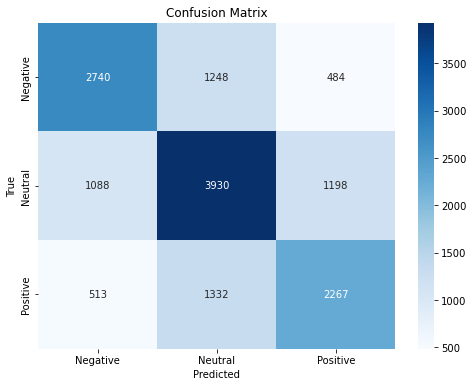

Decision Tree Model Evaluation:
              precision    recall  f1-score   support

    Negative       0.83      0.79      0.81      4472
     Neutral       0.78      0.85      0.81      6216
    Positive       0.81      0.74      0.77      4112

    accuracy                           0.80     14800
   macro avg       0.81      0.79      0.80     14800
weighted avg       0.80      0.80      0.80     14800



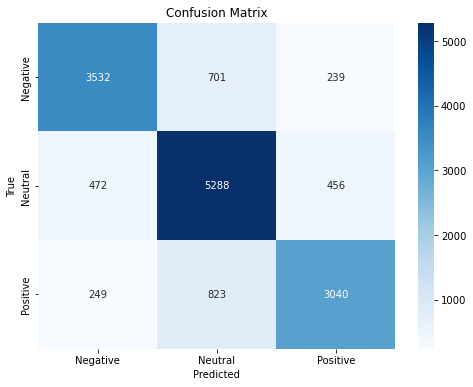

Logistic Regression Model Evaluation:
              precision    recall  f1-score   support

    Negative       0.68      0.61      0.64      4472
     Neutral       0.60      0.71      0.65      6216
    Positive       0.62      0.52      0.56      4112

    accuracy                           0.63     14800
   macro avg       0.63      0.61      0.62     14800
weighted avg       0.63      0.63      0.62     14800



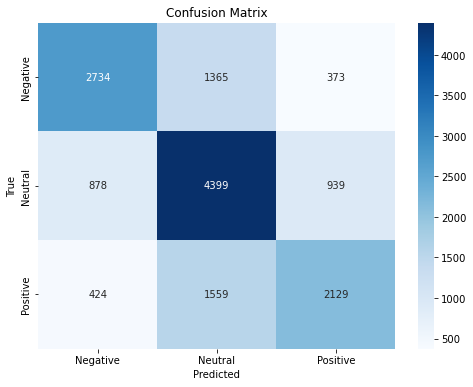

Random Forest Model Evaluation:
              precision    recall  f1-score   support

    Negative       0.89      0.84      0.86      4472
     Neutral       0.82      0.90      0.85      6216
    Positive       0.87      0.80      0.83      4112

    accuracy                           0.85     14800
   macro avg       0.86      0.84      0.85     14800
weighted avg       0.85      0.85      0.85     14800



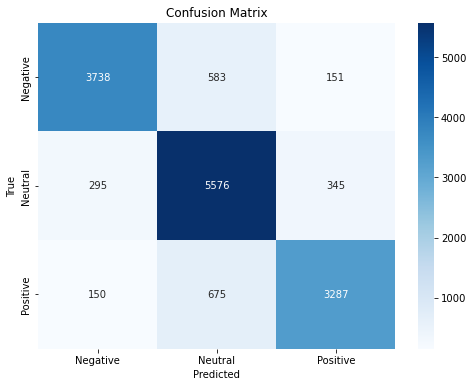

In [26]:
labels = ["Negative", "Neutral", "Positive"]

# Evaluation and visualization of the Naive Bayes model
print("Naive Bayes Model Evaluation:")
print(classification_report(y_test, pred, target_names=labels))
plot_confusion_matrix(y_test, pred, labels=labels)

# Evaluation and visualization of the Decision Tree model
print("Decision Tree Model Evaluation:")
decision_tree_preds = model.predict(X_test)
print(classification_report(y_test, decision_tree_preds, target_names=labels))
plot_confusion_matrix(y_test, decision_tree_preds, labels=labels)

# Evaluation and visualization of the Logistic Regression model
print("Logistic Regression Model Evaluation:")
print(classification_report(y_test, logistic_preds, target_names=labels))
plot_confusion_matrix(y_test, logistic_preds, labels=labels)

# Evaluation and visualization of the Random Forest model
print("Random Forest Model Evaluation:")
print(classification_report(y_test, rf_preds, target_names=labels))
plot_confusion_matrix(y_test, rf_preds, labels=labels)
